In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diamond-price-prediciton-2024/train.csv
/kaggle/input/diamond-price-prediciton-2024/test.csv
/kaggle/input/diamonds/diamonds.csv


# Load Dataset

In [73]:
df = pd.read_csv("/kaggle/input/diamond-price-prediciton-2024/train.csv")
df_valid = pd.read_csv("/kaggle/input/diamond-price-prediciton-2024/test.csv")

# Data Cleaning

In [74]:
df = df.drop(df[df['x'] == 0].index)
df = df.drop(df[df['y'] == 0].index)
df = df.drop(df[df['z'] == 0].index)

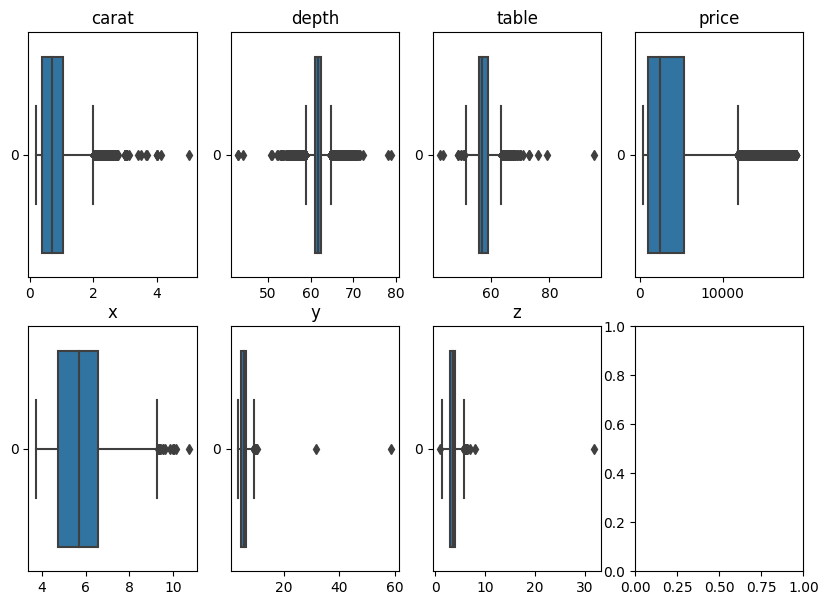

In [75]:
fig, axes = plt.subplots(2,4, figsize=(10,7))
for col,ax in zip(df.select_dtypes(np.number).columns.drop("Id"), axes.flatten()):
    sns.boxplot(df[col], ax=ax, orient="h")
    ax.title.set_text(col)

## Remove outliers using IQR

In [76]:
def IQR(data:pd.Series, whis:float = 1.5):
    Q1, Q3 = np.quantile(data, [0.25,0.75])
    IQR = Q3-Q1
    lower_boundary = Q1 - whis * IQR
    upper_boundary = Q3 + whis * IQR
    return (lower_boundary,upper_boundary)

print("Outliers")
for i in df.select_dtypes(np.number).columns.drop("Id"):
    print(f"{i}\t{(~df[i].between(*IQR(df[i]))).sum()/len(df)*100:0.2f}%")
    df = df[df[i].between(*IQR(df[i]))]

Outliers
carat	3.47%
depth	5.42%
table	0.67%
price	4.89%
x	0.00%
y	0.00%
z	0.01%


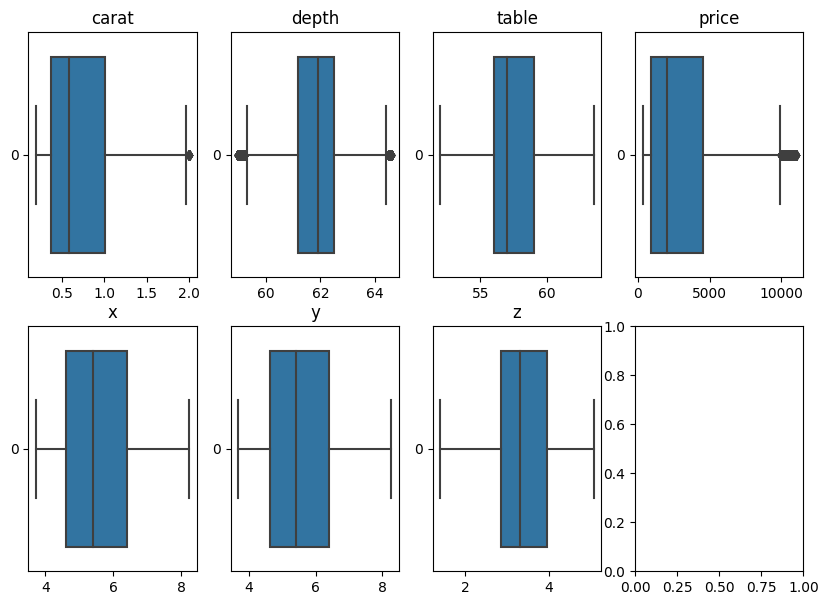

In [77]:
fig, axes = plt.subplots(2,4, figsize=(10,7))
for col,ax in zip(df.select_dtypes(np.number).columns.drop("Id"), axes.flatten()):
    sns.boxplot(df[col], ax=ax, orient="h")
    ax.title.set_text(col)

# Data Prepration

In [78]:
X = df.drop(["price", "Id"], axis = 1)
y = df["price"]

In [79]:
num_cols = X.select_dtypes(np.number).columns
cat_cols = X.columns.drop(num_cols)

## Relationship

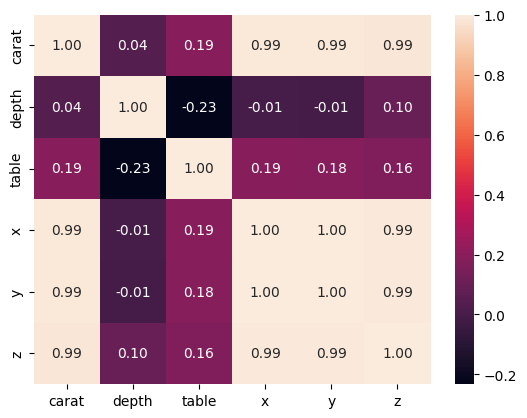

In [80]:
sns.heatmap(X[num_cols].corr(), annot=True, fmt="0.2f");

We've strong correlation between x,y,z,carat

In [81]:
df.select_dtypes(np.number).corr()["price"]

Id       0.001045
carat    0.924594
depth    0.011384
table    0.141695
price    1.000000
x        0.903725
y        0.904849
z        0.900567
Name: price, dtype: float64

In [82]:
columns_to_drop = ["x","y","z"]
X = X.drop(columns_to_drop, axis = 1)
num_cols = num_cols.drop(columns_to_drop)

In [83]:
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_order = ["J", "I", "H", "G", "F", "E", "D"]
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

full_pipe = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(categories=[cut_order, color_order, clarity_order]), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)
full_pipe

ColumnTransformer(transformers=[('cat',
                                 OrdinalEncoder(categories=[['Fair', 'Good',
                                                             'Very Good',
                                                             'Premium',
                                                             'Ideal'],
                                                            ['J', 'I', 'H', 'G',
                                                             'F', 'E', 'D'],
                                                            ['I1', 'SI2', 'SI1',
                                                             'VS2', 'VS1',
                                                             'VVS2', 'VVS1',
                                                             'IF']]),
                                 Index(['cut', 'color', 'clarity'], dtype='object')),
                                ('num', StandardScaler(),
                                 Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])

In [84]:
X = full_pipe.fit_transform(X)
y = y.values.reshape(-1,1)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [86]:
models = [LinearRegression(), DecisionTreeRegressor(),RandomForestRegressor(n_estimators=50,random_state=42)]

for model in models:
    print(model)
    model.fit(X_train,y_train.ravel())
    
    train_pred = model.predict(X_train)
    train_score = mean_squared_error(y_train, train_pred, squared=False)
    print("train:",train_score)
    
    test_pred = model.predict(X_test)
    test_score = mean_squared_error(y_test, test_pred, squared=False)
    print("test:",test_score)
    
    cv_score = -cross_val_score(model, X,y.ravel(), cv=2, scoring="neg_root_mean_squared_error").mean()
    print("cv:",cv_score)
    print("".center(30, "-"))


LinearRegression()
train: 756.4467277987452
test: 761.8628433820528
cv: 758.3048451867526
------------------------------
DecisionTreeRegressor()
train: 3.816598819514121
test: 472.45321074173944
cv: 485.092493990452
------------------------------
RandomForestRegressor(n_estimators=50, random_state=42)
train: 133.06817958405338
test: 352.8603320304566
cv: 355.9074150625934
------------------------------


In [87]:
param_grid = {"n_estimators":[10,20,30,40,50],'max_depth': [15], 'max_features': [15]}

grid_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=2, scoring="neg_root_mean_squared_error")
grid_cv.fit(X, y.ravel())

GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [15], 'max_features': [15],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='neg_root_mean_squared_error')

In [88]:
print(grid_cv.best_params_)
print(-grid_cv.best_score_)
print(grid_cv.best_estimator_)

{'max_depth': 15, 'max_features': 15, 'n_estimators': 50}
353.91679733180445
RandomForestRegressor(max_depth=15, max_features=15, n_estimators=50)


In [89]:
grid_cv.best_index_

4

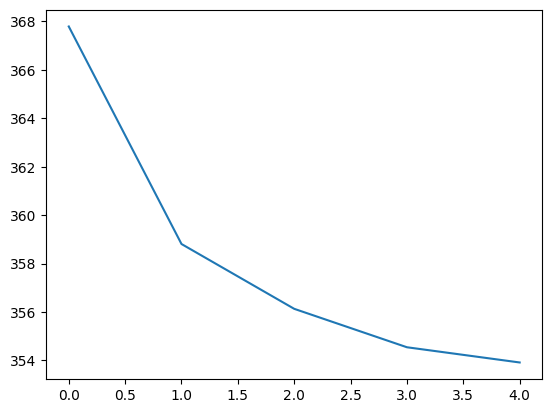

In [90]:
plt.plot(-pd.DataFrame(grid_cv.cv_results_)["mean_test_score"]);

In [91]:
from sklearn.metrics import r2_score
print(r2_score(y_train, grid_cv.best_estimator_.predict(X_train)))
print(r2_score(y_test, grid_cv.best_estimator_.predict(X_test)))

0.995345203692496
0.9951390022366751


In [101]:
Id = df_valid["Id"]

In [103]:
X_valid = df_valid.drop("Id", axis=1)
X_valid

,carat,cut,color,clarity,depth,table,x,y,z
0,0.34,Ideal,G,VVS2,61.1,57.0,4.52,4.48,2.75
1,0.71,Premium,E,VS2,62.7,58.0,5.74,5.68,3.58
2,0.44,Very Good,I,VS1,62.8,56.0,4.83,4.88,3.05
3,0.81,Premium,E,SI2,60.1,59.0,6.09,6.03,3.65
4,0.40,Ideal,G,VVS1,61.2,56.0,4.74,4.80,2.92
...,...,...,...,...,...,...,...,...,...
10783,0.57,Ideal,H,VS1,60.9,56.0,5.34,5.36,3.26
10784,1.05,Ideal,G,VS2,60.8,57.0,6.65,6.58,4.02
10785,0.71,Ideal,E,VVS1,62.3,55.0,5.68,5.72,3.55
10786,1.11,Premium,E,SI2,61.0,60.0,6.68,6.66,4.07


In [ ]:
X_valid= full_pipe.transform(X_valid)

In [110]:
price = grid_cv.best_estimator_.predict(X_valid)

In [114]:
result = pd.DataFrame()
result["Id"] = Id
result["Price"] = price
result

,Id,Price
0,1,917.495260
1,2,2206.003057
2,3,849.569108
3,4,2334.767343
4,5,1022.276110
...,...,...
10783,10784,1619.985997
10784,10785,4358.402500
10785,10786,3276.990000
10786,10787,3962.621940
